# Frozen Lake

 * https://gym.openai.com/envs/FrozenLake-v0
 * Inspired by https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0#.91x58km60



In [2]:
import gym
import numpy as np

In [3]:
# slipperly lake, so actions not deterministic!
env = gym.make('FrozenLake-v0')

env.render()

next_s, r, is_end, inf = env.step(action=0)
print(next_s, r, is_end, inf)
env.render()

next_s, r, is_end, inf = env.step(action=1)
print(next_s, r, is_end, inf)
env.render()

next_s, r, is_end, inf = env.step(action=2)
print(next_s, r, is_end, inf)
env.render()

next_s, r, is_end, inf = env.step(action=3)
print(next_s, r, is_end, inf)
env.render()

[2017-03-02 09:28:46,429] Making new env: FrozenLake-v0


SFFF
FHFH
FFFH
HFFG

0 0.0 False {'prob': 0.3333333333333333}
SFFF
FHFH
FFFH
HFFG
  (Left)
1 0.0 False {'prob': 0.3333333333333333}
SFFF
FHFH
FFFH
HFFG
  (Down)
5 0.0 True {'prob': 0.3333333333333333}
SFFF
FHFH
FFFH
HFFG
  (Right)
5 0 True {'prob': 1.0}
SFFF
FHFH
FFFH
HFFG
  (Up)


## Tabular Q learning

See https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node65.html

![alt text](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/numeqtmp31.png "Q learning update rule")


In [4]:
import math
import random

def one_step_update(Q, s, a, r, next_s, alpha, gamma):
    Q[s, a] += alpha * (r + gamma * Q[next_s, :].max() - Q[s, a])
    return Q

def eps_greedy_action(Q, s, epsilon):
    return random.choice(np.arange(Q.shape[1])) if (random.uniform(0, 1) <= epsilon) else Q[s, :].argmax()


class QLearning:
    def __init__(self, Q, epsilon, alpha=0.1, gamma=.99):
        self.Q = Q
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.n_episodes = 0
        
    def take_step(self, env, s):
        # decayed and first
        epsilon = (self.epsilon / (1 + self.n_episodes)) if (self.n_episodes <= 5000) else 0
        a = eps_greedy_action(self.Q, s, epsilon)
        next_s, r, is_end, _ = env.step(a)
        self.Q = one_step_update(self.Q, s, a, r, next_s, self.alpha, self.gamma)
        
        if is_end:
            self.n_episodes += 1

        return next_s, r, is_end
    
    @classmethod
    def create(cls, epsilon=10, alpha=0.1, gamma=.99):
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        return cls(Q, epsilon, alpha, gamma)

def play_new_episode(env, act_func):
    s = env.reset()
    is_end = False
    i = 0
    while (not is_end) and i < 100:
        i += 1
        s, r, is_end = act_func(env, s)
        yield r

In [5]:
def capture_new_episode(env, act_func):
    rewards, debugs = zip(*[(r, env.render(mode='ansi')) for r in play_new_episode(env, act_func)])
    return sum(rewards), '\n'.join(d.getvalue() for d in debugs)

total_reward, debug = capture_new_episode(env, QLearning.create().take_step)

print(debug)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Down)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Down)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Down)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Down)

SFFF
FHFH
FFFH
HFFG
  (Right)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Down)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Right)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Down)

SFFF
FHFH
FFFH
HFFG
  (Right)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Right)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Up)



0.06


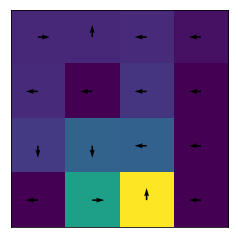

In [15]:
n_episodes = 500
qlearn = QLearning.create(epsilon=100)

simulated_episodes = (play_new_episode(env, qlearn.take_step) for _ in range(n_episodes))
average_reward = sum(sum(rs) for rs in simulated_episodes) / n_episodes
print(average_reward)

from matplotlib import pyplot as plt
%matplotlib inline

def showQ(Q):
    actions_grid = Q.argmax(1).reshape((4, 4))
    values_grid = Q.max(1).reshape((4, 4))

    actions_xys = np.array([
        [-1, 0], #L
        [0, -1], #D
        [1, 0], #R
        [0, 1], #U
    ])

    actions_x_grid = actions_xys[actions_grid, 0]
    actions_y_grid = actions_xys[actions_grid, 1]

    plt.imshow(values_grid, interpolation='nearest')

    plt.quiver(actions_x_grid, actions_y_grid)

    plt.xticks([]); plt.yticks([]);

showQ(qlearn.Q)

In [310]:
n_episodes = 100

simulated_episodes = (capture_new_episode(env, QLearning(qlearn.Q, epsilon=0).take_step) for _ in range(n_episodes))

average_reward = sum(total_reward for total_reward, _ in simulated_episodes) / n_episodes
print(average_reward)

0.72


In [321]:
simulated_episodes = (capture_new_episode(env, QLearning(qlearn.Q, epsilon=0.).take_step) for _ in range(n_episodes))
first_winning_debug = next(debug for total_reward, debug in simulated_episodes 
                           if (total_reward > 0 and len(debug) < 300))
print(first_winning_debug)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Up)

SFFF
FHFH
FFFH
HFFG
  (Down)

SFFF
FHFH
FFFH
HFFG
  (Left)

SFFF
FHFH
FFFH
HFFG
  (Down)



In [311]:
qlearn = QLearning.create(epsilon=100)

import gym
from gym import wrappers

env = wrappers.Monitor(gym.make('FrozenLake-v0'), '/tmp/FrozenLake-v0', force=True)

for i_episode in range(10000):
    r = sum(play_new_episode(env, qlearn.take_step))

env.close()

[2017-02-19 00:46:50,628] Making new env: FrozenLake-v0
[2017-02-19 00:46:50,636] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-19 00:46:50,638] Clearing 26 monitor files from previous run (because force=True was provided)
[2017-02-19 00:46:50,641] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.7.47835.video000000.json
[2017-02-19 00:46:50,644] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.7.47835.video000001.json
[2017-02-19 00:46:50,648] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.7.47835.video000008.json
[2017-02-19 00:46:50,653] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.7.47835.video000027.json
[2017-02-19 00:46:50,666] Starting new video recorder writing to

In [312]:
gym.upload('/tmp/FrozenLake-v0', api_key='sk_bNZUvCfkTfabQCoKoKbjFA')

[2017-02-19 00:47:00,333] [FrozenLake-v0] Uploading 10000 episodes of training data
[2017-02-19 00:47:12,078] [FrozenLake-v0] Uploading videos of 19 training episodes (2124 bytes)
[2017-02-19 00:47:12,595] [FrozenLake-v0] Creating evaluation object from /tmp/FrozenLake-v0 with learning curve and training video
[2017-02-19 00:47:12,926] 
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_sYk0FCES1iR4JPQJxfpmA

****************************************************
